In [1]:
import os
import re
import pandas as pd
import glob
from dotenv import load_dotenv
import requests
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
geocodes = pd.read_excel("./GEOCodesLookup/all-geocodes-v2020.xlsx", skiprows = 4, dtype = str)

In [3]:
geocodes = geocodes[geocodes["State Code (FIPS)"] == "06"]

In [4]:
geocodes = geocodes.rename(columns = {"Area Name (including legal/statistical area description)": "CountyName"})

## Census Demographic Census Data from 2023

In [6]:
user = os.path.expanduser("~")

In [7]:
load_dotenv(os.path.join(user, "Documents", ".env"))

False

In [8]:
key = os.getenv("CENSUS_API_KEY")

In [9]:
url = "https://api.census.gov/data/2023/acs/acs5"

In [10]:
vars = [
    "NAME",
    "B01003_001E",
    "B01001_001E",
    "B02001_001E",
    "B03003_003E",
    "B19013_001E",
    "B15003_022E",
    "B15003_023E",
    "B15003_024E",
    "B15003_025E",
    "B23025_003E",
    "B23025_005E",
    "B25064_001E",
    "B25077_001E",
    "B07001_017E",
    "B07001_081E",
    "B07001_085E",
    "B25003_002E",
    "B25003_003E"
]

In [11]:
params = {"get" : ",".join(vars), "for" : "county:*"}

In [12]:
response = requests.get(url, params = params)

In [13]:
demographics = pd.DataFrame(response.json()[1:], columns = response.json()[0])

In [14]:
rename_map = {
    "NAME": "CountyName",
    "B01003_001E": "total_population",
    "B01001_001E": "total_age_population",
    "B02001_001E": "total_race_population",
    "B03003_003E": "hispanic_or_latino",
    "B19013_001E": "median_household_income",
    "B15003_022E": "bachelors_degree",
    "B15003_023E": "masters_degree",
    "B15003_024E": "professional_degree",
    "B15003_025E": "doctorate_degree",
    "B23025_003E": "labor_force",
    "B23025_005E": "unemployed",
    "B25064_001E": "median_rent",
    "B25077_001E": "median_home_value",
    "B07001_017E": "same_house_1yr_ago",
    "B07001_081E": "moved_from_same_state",
    "B07001_085E": "moved_from_different_state",
    "B25003_002E": "owner_occupied",
    "B25003_003E": "renter_occupied",
    "state": "state_fips",
    "county": "county_fips"
}

demographics = demographics.rename(columns = rename_map)

# Synthetic LODES (Where people live [RAC] vs where they work [WAC] | 2018 - 2022)

https://lehd.ces.census.gov/data/

https://www.census.gov/geographies/mapping-files/2024/geo/tiger-line-file.html

In [18]:
rac_files = glob.glob("./LODES/ca_rac_S000_JT00_*.csv.gz")
wac_files = glob.glob("./LODES/ca_wac_S000_JT00_*.csv.gz")

In [19]:
def read_lehd_file(file_path):
    # Extract year from filename
    year = int(os.path.basename(file_path).split("_")[-1].split(".")[0])
    
    # Read CSV (gzip compressed)
    df = pd.read_csv(file_path, dtype = {"h_geocode": str, "w_geocode": str})
    
    # Add year column
    df["year"] = year
    
    return df


In [20]:
rac_list = [read_lehd_file(f) for f in rac_files]
rac_df = pd.concat(rac_list, ignore_index=True)

In [21]:
wac_list = [read_lehd_file(f) for f in wac_files]
wac_df = pd.concat(wac_list, ignore_index=True)

In [22]:
rac_df["state_fips"] = rac_df["h_geocode"].str[:2] # first 2 digits = state
rac_df["county_fips"] = rac_df["h_geocode"].str[2:5] # next 3 digits = county
rac_df["county_fips"] = rac_df["state_fips"] + rac_df["county_fips"] # full 5-digit FIPS

In [23]:
wac_df["state_fips"] = wac_df["w_geocode"].str[:2] # first 2 digits = state
wac_df["county_fips"] = wac_df["w_geocode"].str[2:5] # next 3 digits = county
wac_df["county_fips"] = wac_df["state_fips"] + wac_df["county_fips"] # full 5-digit FIPS

In [24]:
rac_county = rac_df.groupby(["county_fips","year"])["C000"].sum().reset_index()
rac_county = rac_county.rename(columns = {"C000":"workers_living"})

In [25]:
wac_county = wac_df.groupby(["county_fips","year"])["C000"].sum().reset_index()
wac_county = wac_county.rename(columns = {"C000":"jobs_located"})

In [26]:
county_flow = rac_county.merge(wac_county, on = ["county_fips","year"])
county_flow["net_inflow"] = county_flow["jobs_located"] - county_flow["workers_living"]

In [27]:
county_flow["county_fips"] = county_flow["county_fips"].str[2:5]

In [28]:
county_flow = county_flow.merge(
    geocodes[["County Code (FIPS)", "CountyName"]],
    left_on = "county_fips",
    right_on = "County Code (FIPS)",
    how = "left"
)

In [29]:
county_flow

,county_fips,year,workers_living,jobs_located,net_inflow,County Code (FIPS),CountyName
0,001,2018,810472,813398,2926,001,Alameda County
1,001,2019,817258,807148,-10110,001,Alameda County
2,001,2020,767415,752402,-15013,001,Alameda County
3,001,2021,756046,767190,11144,001,Alameda County
4,001,2022,801985,819506,17521,001,Alameda County
...,...,...,...,...,...,...,...
285,115,2018,27305,15755,-11550,115,Yuba County
286,115,2019,27826,16194,-11632,115,Yuba County
287,115,2020,28849,16937,-11912,115,Yuba County
288,115,2021,29956,16404,-13552,115,Yuba County


# IRS Migration Data

https://www.irs.gov/statistics/soi-tax-stats-migration-data

In [32]:
irs_data_path = r"./IRSMigration"

In [33]:
csv_files = glob.glob(os.path.join(irs_data_path, "*.csv"))

In [34]:
irs_data = {}

for file in csv_files:
    fname = os.path.splitext(os.path.basename(file))[0]

    # get year portion from filename
    year_str = "20" + fname[-2:]
    
    df = pd.read_csv(file, dtype=str, encoding="latin1")

    # add a column for the year
    df["year_ending_in"] = year_str

    # add column for inflow/outflows
    if "inflow" in fname.lower():
        df["flow_type"] = "inflow"
    elif "outflow" in fname.lower():
        df["flow_type"] = "outflow"
    else:
        df["flow_type"] = "unknown"

    # save to dictionary
    irs_data[fname] = df

In [35]:
# combine into one data frame
irs_data_combined = pd.concat(irs_data.values(), ignore_index=True)

In [36]:
# some strings are incorrect (there exist some that are 06 or 6, which mean the same)
# coerce into ints to solve this problem
fips_colnames = ["y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips"]
for col in fips_colnames:
    irs_data_combined[col] = pd.to_numeric(
        irs_data_combined[col]
    )

In [37]:
irs_ca = irs_data_combined[(irs_data_combined["y2_statefips"] == 6) | (irs_data_combined["y1_statefips"] == 6) ]

In [38]:
for col in ["n1", "n2", "agi", "year_ending_in"]:
    irs_ca[col] = pd.to_numeric(irs_ca[col])

C:\Users\Chris\AppData\Local\Temp\ipykernel_4108\3134775981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  irs_ca[col] = pd.to_numeric(irs_ca[col])


In [39]:
# find inflow (where people move to California)
irs_in = irs_ca[(irs_ca["y2_statefips"] == 6) & (irs_ca["flow_type"] == "inflow")]
inflow = irs_in.groupby(["y2_countyfips", "year_ending_in"], as_index=False).agg({
    "n2": "sum",
    "agi": "sum"
}).rename(columns={"y2_countyfips": "countyfips", "n2": "total_inflow", "agi": "total_agi_in"})

In [40]:
# outflow (where people leave California)
irs_out = irs_ca[(irs_ca["y1_statefips"] == 6) & (irs_ca["flow_type"] == "outflow")]
outflow = irs_out.groupby(["y1_countyfips", "year_ending_in"], as_index=False).agg({
    "n1": "sum",
    "agi": "sum"
}).rename(columns={"y1_countyfips": "countyfips", "n1": "total_outflow", "agi": "total_agi_out"})

In [41]:
# merge inflow and outflow
county_migration = inflow.merge(outflow, on = ["countyfips", "year_ending_in"], how = "outer").fillna(0)

In [42]:
# find net migration
county_migration["net_migration"] = county_migration["total_inflow"] - county_migration["total_outflow"]
county_migration["net_agi"] = county_migration["total_agi_in"] - county_migration["total_agi_out"]

In [43]:
# repad zeros for countyfips
county_migration["countyfips"] = county_migration["countyfips"].astype(str).str.zfill(3)

# CAR

Data gathered here: https://www.car.org/marketdata/data

[Historical Housing Affordability Index](https://carorg.sharepoint.com/:x:/s/CAR-RE-PublicProducts/EVgvL6PVxElFtDjAUhmBYtIBkgQMH5SsbBdeYyBIks9R9w)

[Median Time of Homes On Market](https://carorg.sharepoint.com/:x:/s/CAR-RE-PublicProducts/EaAOiWPma41ArHBWwYRGQMoBlUe5JMxKixyQ0idvrn7i7Q)

[Median Prices of Homes](https://carorg.sharepoint.com/:x:/s/CAR-RE-PublicProducts/EQr6lTtx5_hCmRawI-XHBkoBt0otrc47S8XAem4f8UAMrw)

[Unsold Inventory Index](https://carorg.sharepoint.com/:x:/s/CAR-RE-PublicProducts/EcDFUV4JrPtFofTmqhdiPCoBQ7S1MVK9IFU3A6BE6mt9hA)

In [50]:
hai = pd.read_csv("./CARS/Historical Housing Affordability Index(Trad.csv", skiprows = 3)
hai = hai.iloc[120:, :]

In [51]:
dom = pd.read_csv("./CARS/MedianTimeonMarketofExistingDetachedHomesHistoricalData(DOM).csv", skiprows = 3)
dom = dom.iloc[132:, :]

In [52]:
prices = pd.read_csv("./CARS/MedianPricesofExistingDetachedHomesHistoricalData(Median Price).csv", skiprows = 7)
prices = prices.iloc[132:, :]

In [53]:
uii = pd.read_csv("./CARS/UnsoldInventoryIndexofExistingDetachedHomesHistoricalData(UII).csv", skiprows = 12)
uii = uii.iloc[132:, :]

In [54]:
def pivot_df(df, value_name, var_name = "County"):
    
    # drop columns that do not exist in some data
    drop_cols = ["Condo", "LA Metro", "Central Coast", "Central Valley", "Far North", "Inland Empire", "SF Bay Area", "S.F. Bay Area", "SoCal", "Contra-Costa", "Mariposa"]
    df = df.drop(columns = [c for c in drop_cols if c in df.columns])

    # rename LA to Los Angeles for consistency
    df = df.rename(columns = {"LA": "Los Angeles"})

    # convert dates to correct format
    df[["Year", "Month"]] = df["Mon-Yr"].str.split("-", expand = True)
    df["Year"] = "20" + df["Year"].str.zfill(2)
    df["Date"] = pd.to_datetime(df["Year"] + "-" + df["Month"], format = "%Y-%b")

    # drop uneeded columns for pivoting
    df = df.drop(["Mon-Yr", "Year", "Month"], axis = 1)

    # pivot rows
    df_long = df.melt(id_vars = ["Date"], var_name = var_name, value_name = value_name)
    
    return df_long

In [55]:
prices_long = pivot_df(prices, "MedianPrice")
prices_long["MedianPrice"] = prices_long["MedianPrice"].replace(r"[\$,]", "", regex=True).astype(float)

In [56]:
dom_long = pivot_df(dom, "DaysOnMarket")
dom_long["DaysOnMarket"] = pd.to_numeric(dom_long["DaysOnMarket"], errors = "coerce")

In [57]:
uii_long = pivot_df(uii, "UII")
uii_long["UII"] = pd.to_numeric(uii_long["UII"], errors = "coerce")

In [58]:
# change LA to Los Angeles for consistency
hai = hai.rename(columns = {"LA": "Los Angeles"})

# grab the rows that are in the quarter format
hai = hai[hai["Month/QTR"].str.contains(r"20\d{2}\.[1-4]$")].copy()

# pivot rows
hai_long_qtr = hai.melt(id_vars = ["Month/QTR"], var_name = "County", value_name = "HAI")

# change dates to the correct format
hai_long_qtr["Date"] = pd.PeriodIndex(hai_long_qtr["Month/QTR"].astype(str).str.replace(".", "Q"), freq="Q").to_timestamp()
hai_long_qtr["Date"] = hai_long_qtr["Date"].dt.strftime("%Y-%m")
hai_long_qtr["Date"] = pd.to_datetime(hai_long_qtr["Date"], format="%Y-%m")

# drop columns we do not need
hai_long_qtr = hai_long_qtr.drop(columns = ["Month/QTR"])

# change HAI to a number data type
hai_long_qtr["HAI"] = hai_long_qtr["HAI"].replace(r"%", "", regex = True).astype(float) / 100

In [59]:
prices_long_qtr = prices_long.groupby(["County", pd.Grouper(key="Date", freq="QS")])["MedianPrice"].mean().reset_index()

In [60]:
dom_long_qtr = dom_long.groupby(["County", pd.Grouper(key="Date", freq="QS")])["DaysOnMarket"].mean().reset_index()

In [61]:
uii_long_qtr = uii_long.groupby(["County", pd.Grouper(key="Date", freq="QS")])["UII"].mean().reset_index()

In [62]:
def filter_dates(df, date_col = "Date", start_year = 2020):
    return df[df[date_col].dt.year > start_year]

In [63]:
prices_recent = filter_dates(prices_long_qtr)
dom_recent = filter_dates(dom_long_qtr)
uii_recent = filter_dates(uii_long_qtr)
hai_recent = filter_dates(hai_long_qtr)


In [64]:
car_recent_dfs = [prices_recent, dom_recent, uii_recent, hai_recent]
car_recent_dfs_master = reduce(lambda left, right: pd.merge(left, right, on=["County", "Date"], how="inner"), car_recent_dfs)

In [65]:
car_recent_dfs_master["QuarterNumber"] = ((car_recent_dfs_master["Date"].dt.year - 2021) * 4 + car_recent_dfs_master["Date"].dt.quarter)

# Analysis

In [67]:
import statsmodels.api as sm

results = []

for county in car_recent_dfs_master["County"].unique():
    county_df = car_recent_dfs_master[car_recent_dfs_master["County"] == county].copy()
    
    X = county_df[["QuarterNumber"]]
    X = sm.add_constant(X)  # add intercept
    
    y = county_df["MedianPrice"]
    
    model = sm.OLS(y, X).fit()
    
    slope = model.params["QuarterNumber"]
    r_squared = model.rsquared
    
    results.append({
        "County": county,
        "Slope_QuarterNumber": slope,
        "R_squared": r_squared
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by = "Slope_QuarterNumber", ascending = False).reset_index(drop = True)

print(results_df.head(10))


            County  Slope_QuarterNumber  R_squared
0      Santa Clara         22734.590643   0.580800
1           Orange         21135.426901   0.824043
2    Santa Barbara         18731.637427   0.390452
3        San Diego         12663.175439   0.797508
4  San Luis Obispo          9943.766082   0.732361
5      Los Angeles          8754.362573   0.520734
6         Monterey          7605.536842   0.492947
7          Ventura          7368.345029   0.616002
8               CA          6332.046784   0.522727
9       Santa Cruz          6221.929825   0.197505


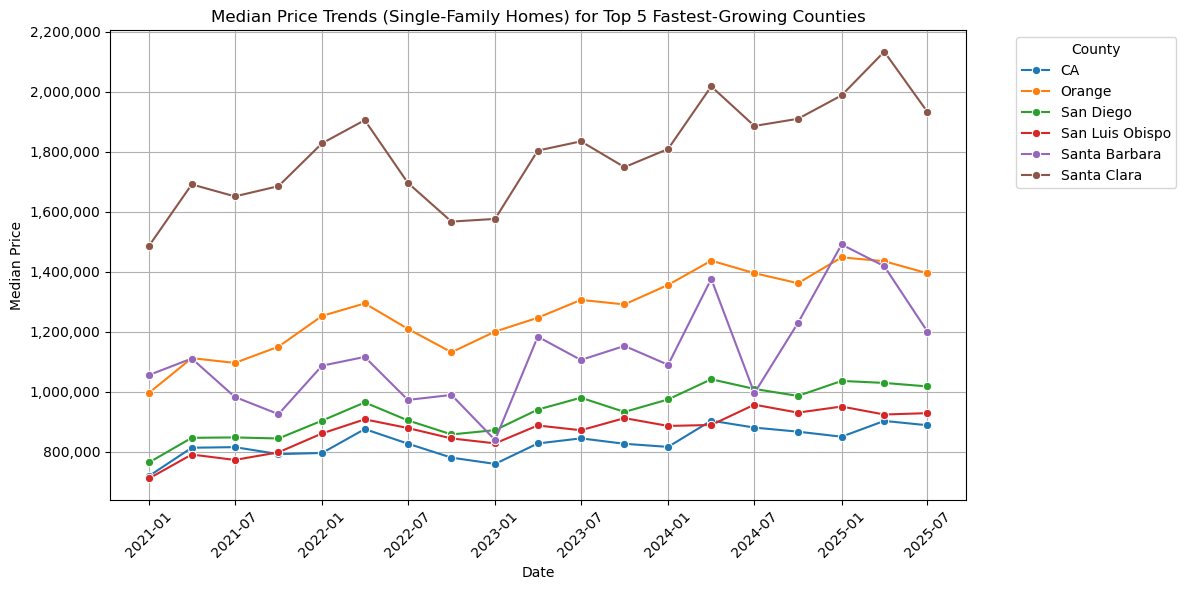

In [68]:
top_counties = results_df.head(5)["County"].tolist()
counties_of_interest = top_counties + ["CA"] # select top counties

top_df = car_recent_dfs_master[car_recent_dfs_master["County"].isin(counties_of_interest)].copy() # filter dataframe for the top counties

plt.figure(figsize = (12, 6)) # plot median prices overtime
sns.lineplot(data = top_df, x = "Date", y = "MedianPrice", hue = "County", marker = "o")

plt.title("Median Price Trends (Single-Family Homes) for Top 5 Fastest-Growing Counties")
plt.xlabel("Date")
plt.ylabel("Median Price")

formatter = FuncFormatter(lambda x, _: f"{int(x):,}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title = "County", bbox_to_anchor = (1.05, 1), loc = "upper left")

plt.xticks(rotation = 45)
plt.tight_layout()
plt.grid()
plt.show()


In [69]:
car_recent_dfs_master["QuarterActual"] = ( (car_recent_dfs_master["QuarterNumber"] - 1) % 4 ) + 1

In [70]:
car_recent_dfs_master["Year"] = car_recent_dfs_master.Date.dt.year

In [71]:
def plot_county_seasonality(df, county, variables=["MedianPrice", "DaysOnMarket", "UII", "HAI"]):

    # filter for selected county
    county_df = df[df["County"] == county]

    # prepare subplots
    fig, axes = plt.subplots(2, 2, figsize = (15, 10))
    axes = axes.flatten()

    # plot heatmap 
    for i, var in enumerate(variables):
        
        # pivot table to get into appropriate format
        pivot_df = county_df.pivot_table(
            index = "Year",
            columns = "QuarterActual",
            values = var
        )
        
        # normalize by row (z-score across quarters)
        pivot_norm = pivot_df.apply(lambda row: (row - row.mean()) / row.std(), axis=1)

        # plot heatmap
        sns.heatmap(
            pivot_norm,
            annot = True,
            cmap = "crest",
            center = 0,
            linewidths = 0.5,
            linecolor = "gray",
            ax = axes[i]
        )
        axes[i].set_title(f"{var} in {county}")
        axes[i].set_xlabel("Quarter")
        axes[i].set_ylabel("Year")

    plt.tight_layout()
    plt.show()


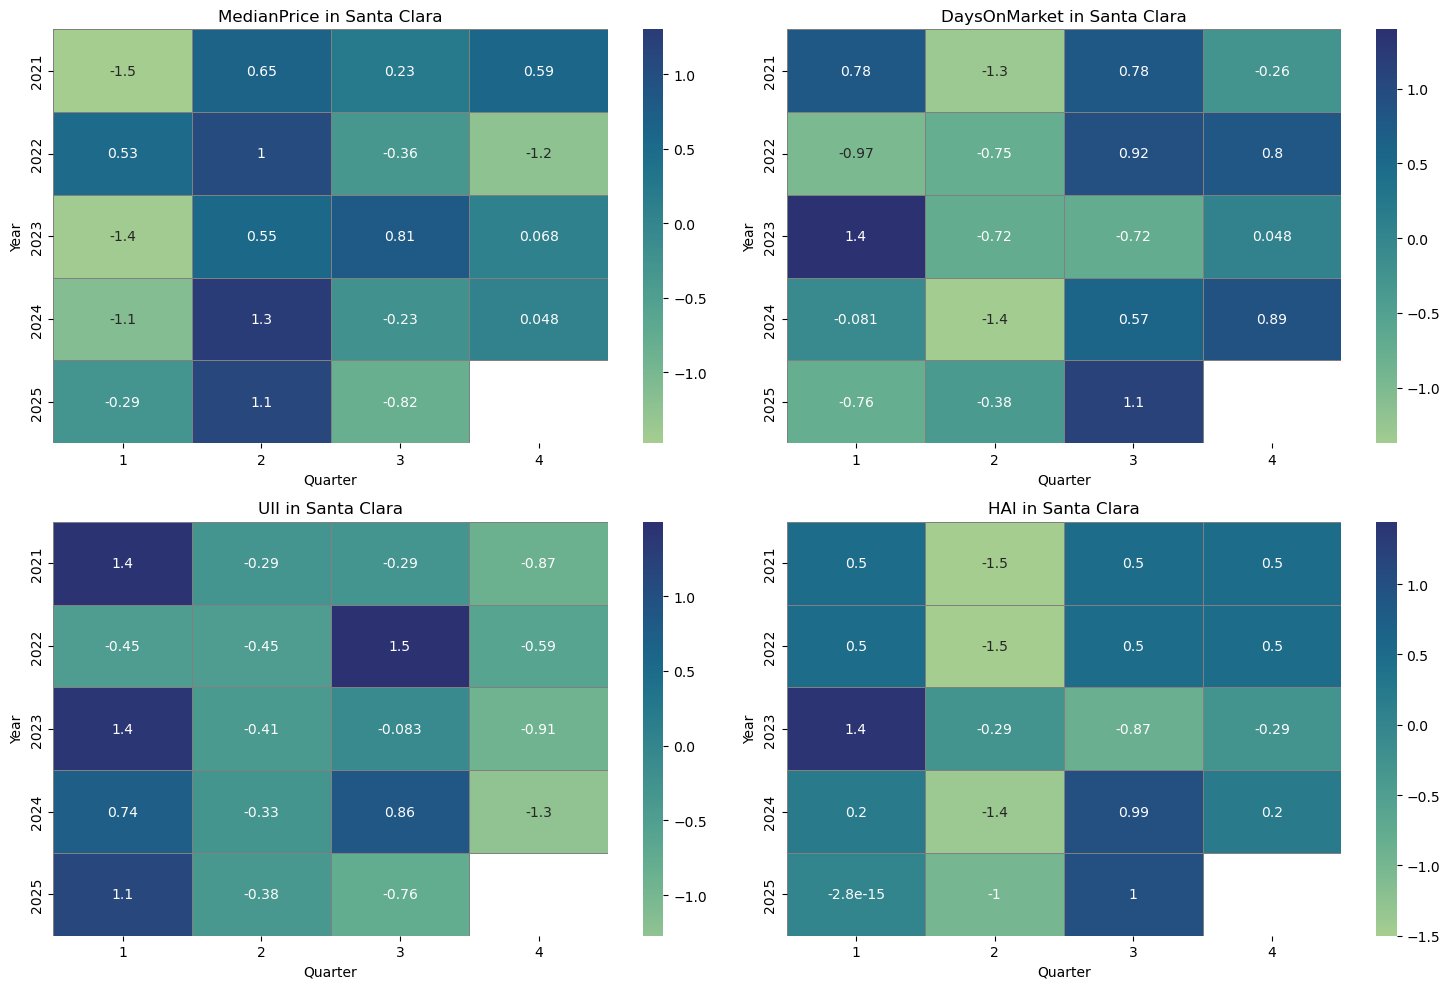

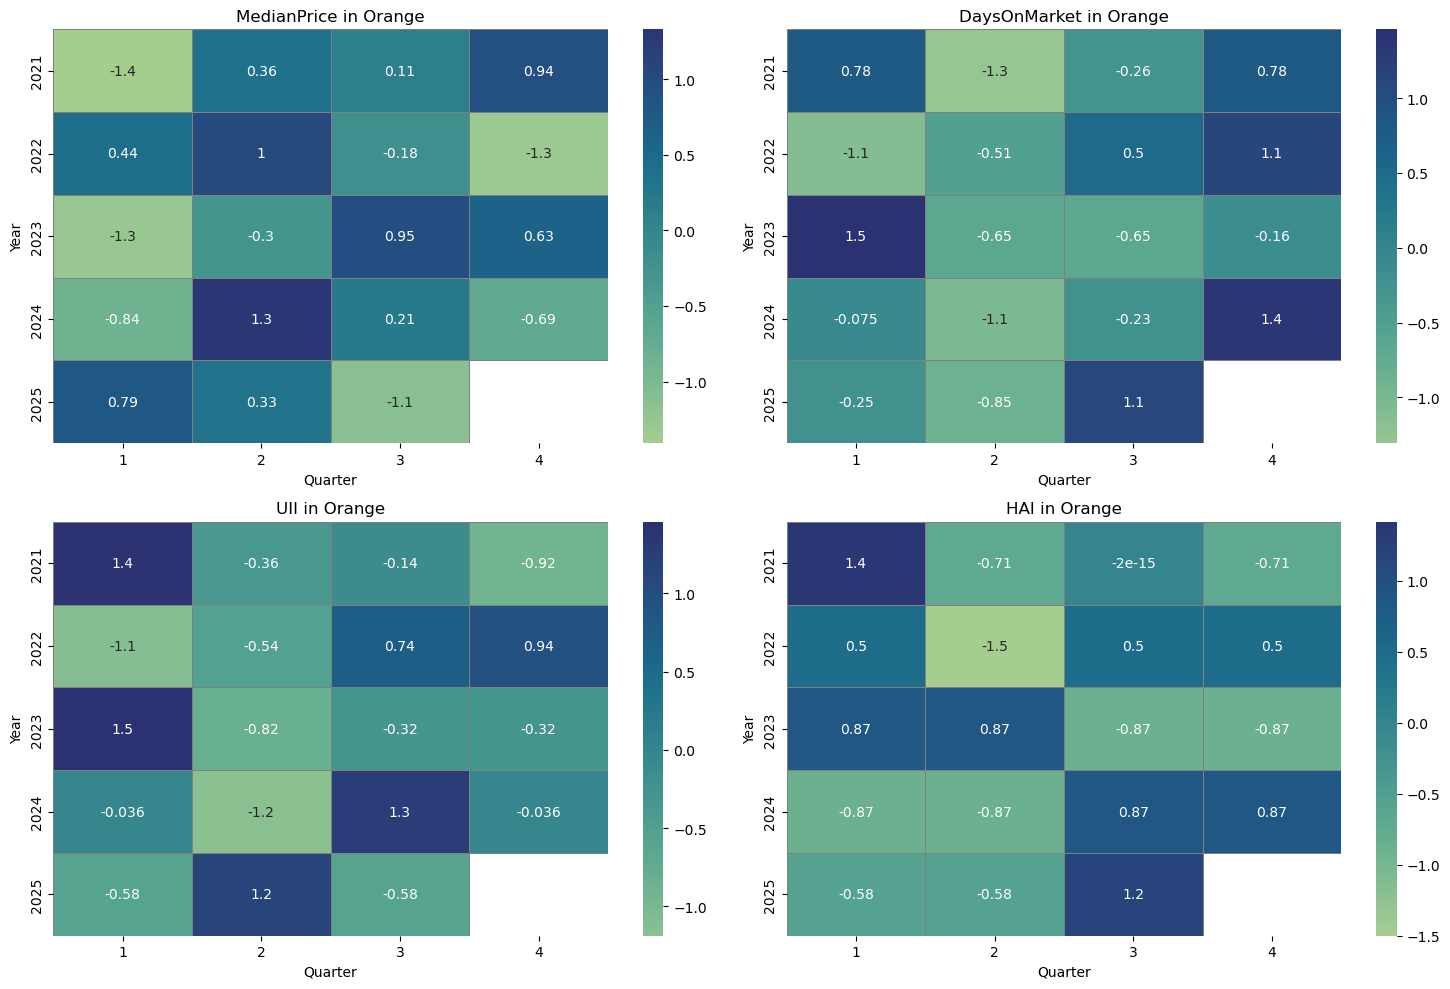

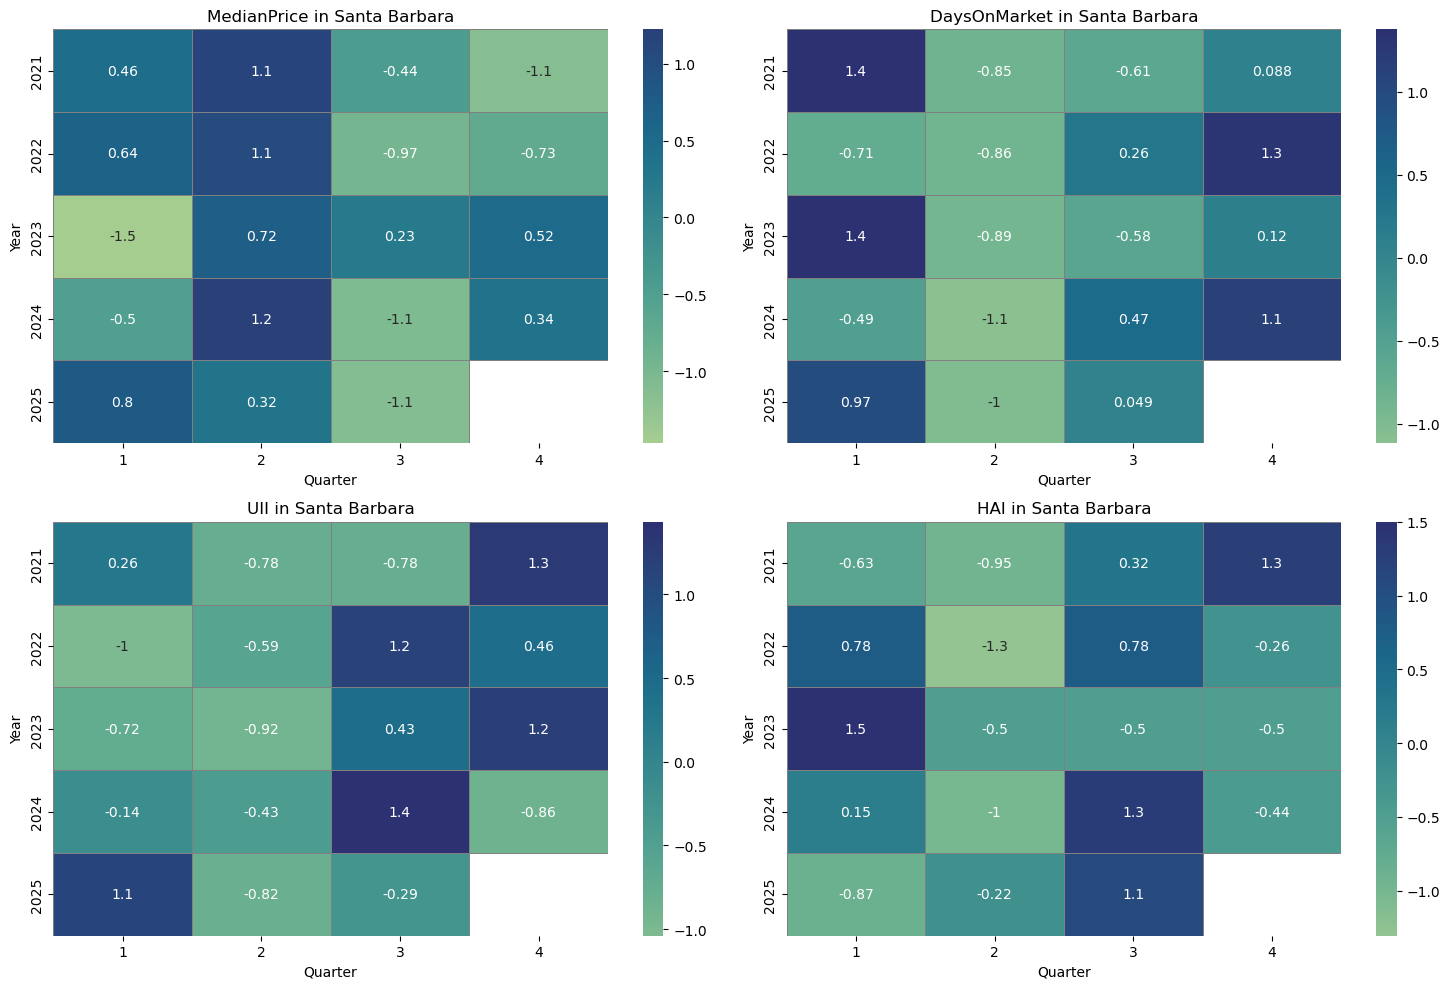

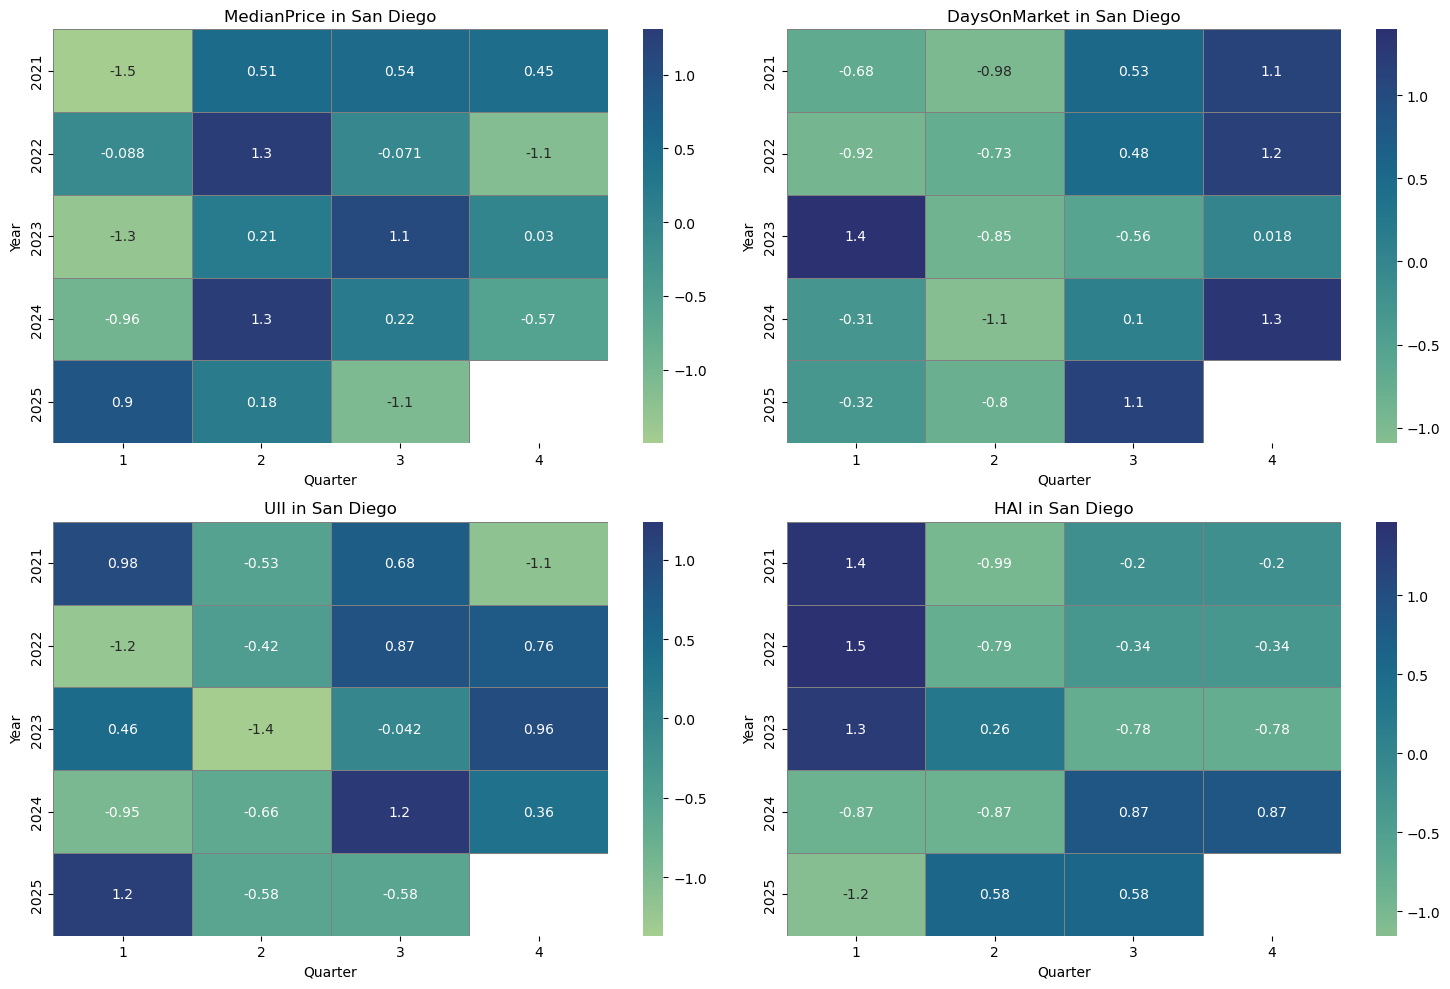

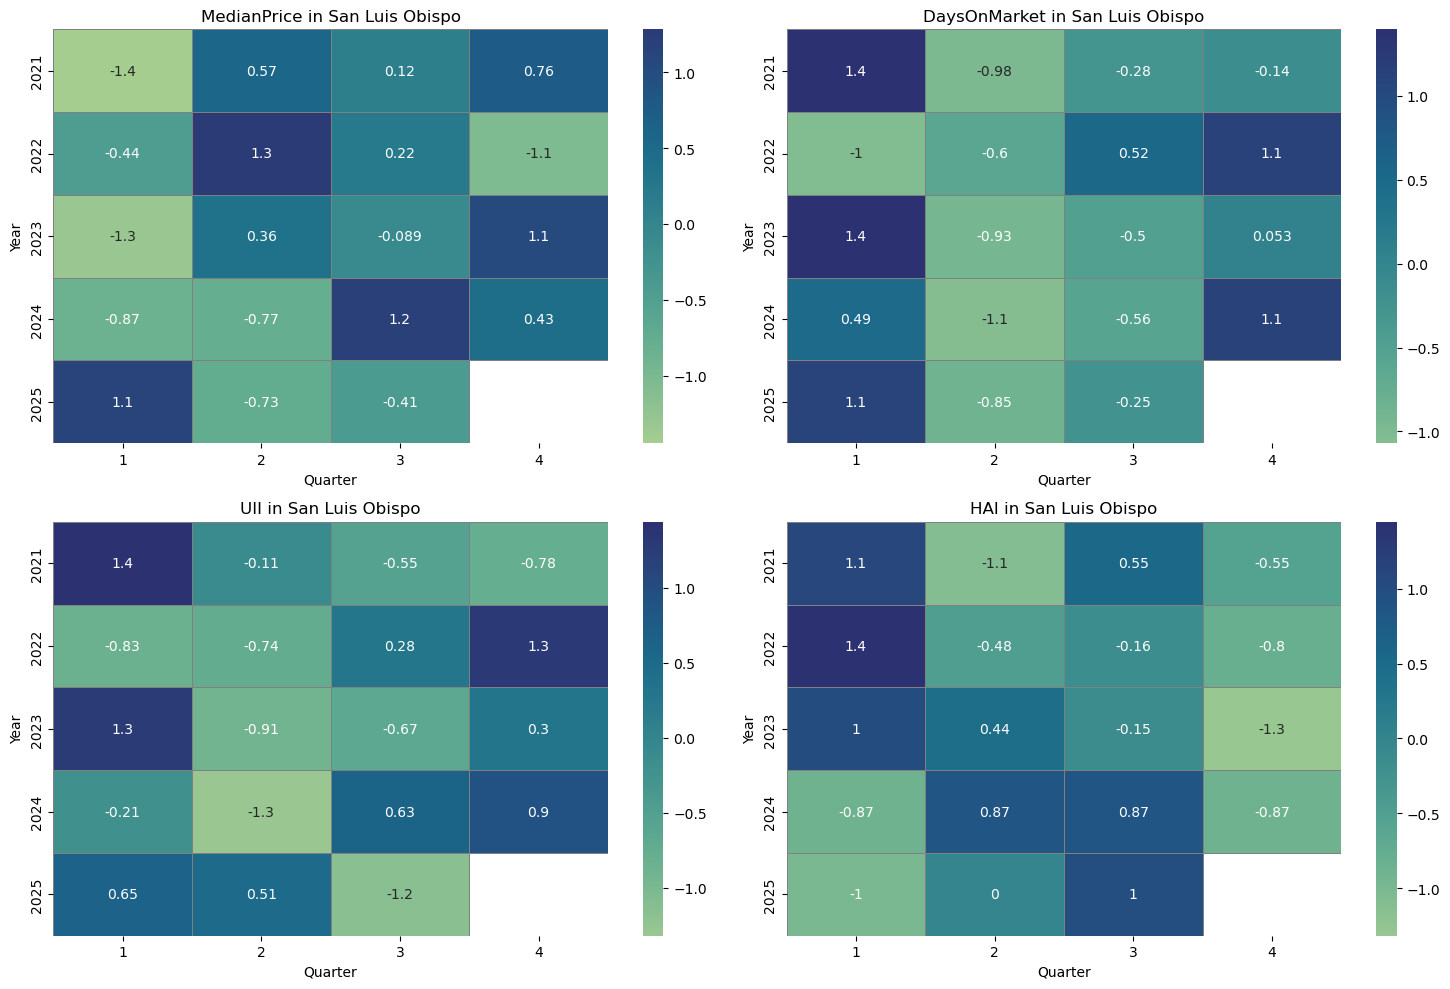

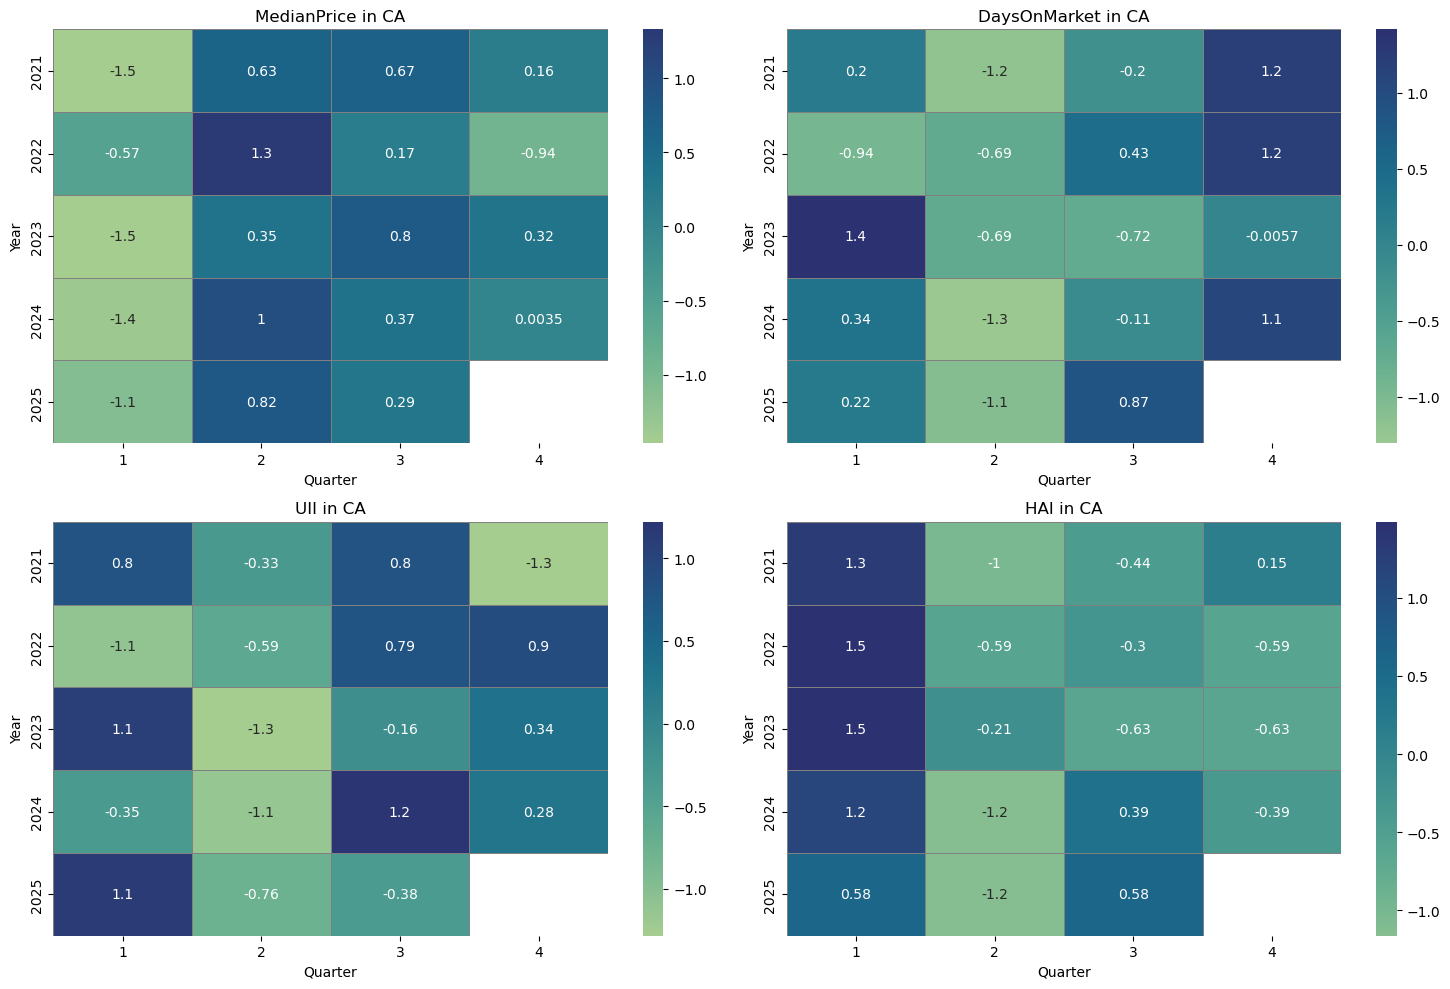

[None, None, None, None, None, None]

In [72]:
[plot_county_seasonality(car_recent_dfs_master, county = county) for county in counties_of_interest]

In [73]:
top_counties_codes = [geocodes[geocodes["CountyName"] == county + " County"]["County Code (FIPS)"].item() for county in top_counties]

In [74]:
def print_migration_table(county_index, county_migration_table = county_migration, top_counties = top_counties, top_counties_codes = top_counties_codes):
    print("County:", top_counties[county_index])
    return county_migration_table[county_migration_table["countyfips"] == top_counties_codes[county_index]]

In [75]:
print_migration_table(0)

County: Santa Clara


,countyfips,year_ending_in,total_inflow,total_agi_in,total_outflow,total_agi_out,net_migration,net_agi
211,085,2018,1895418,156575663,951387,167179563,944031,-10603900
212,085,2019,1886026,169156367,960124,182039613,925902,-12883246
213,085,2020,1866210,163990639,985760,184804181,880450,-20813542
214,085,2021,1754613,184341022,993323,208857627,761290,-24516605
215,085,2022,1786602,237118470,994650,260068960,791952,-22950490


In [76]:
print_migration_table(1)

County: Orange


,countyfips,year_ending_in,total_inflow,total_agi_in,total_outflow,total_agi_out,net_migration,net_agi
146,059,2018,3004036,144956122,1462440,146853704,1541596,-1897582
147,059,2019,2968704,151336970,1468659,152232547,1500045,-895577
148,059,2020,2987761,155732256,1487956,157993801,1499805,-2261545
149,059,2021,2863496,161397305,1532065,169019803,1331431,-7622498
150,059,2022,2902397,196370964,1582841,202936126,1319556,-6565162


In [77]:
print_migration_table(2)

County: Santa Barbara


,countyfips,year_ending_in,total_inflow,total_agi_in,total_outflow,total_agi_out,net_migration,net_agi
206,083,2018,409677,16982176,200129,17253566,209548,-271390
207,083,2019,401166,18001628,199249,18349386,201917,-347758
208,083,2020,405553,19266914,202390,18537069,203163,729845
209,083,2021,385124,21401986,207933,21544831,177191,-142845
210,083,2022,389064,25599635,214313,24527272,174751,1072363


In [78]:
print_migration_table(3)

County: San Diego


,countyfips,year_ending_in,total_inflow,total_agi_in,total_outflow,total_agi_out,net_migration,net_agi
181,073,2018,3121705,129576555,1539363,130602012,1582342,-1025457
182,073,2019,3100785,138344974,1553143,139417763,1547642,-1072789
183,073,2020,3168573,144912732,1580504,145654751,1588069,-742019
184,073,2021,3053995,153431160,1629147,154501121,1424848,-1069961
185,073,2022,3084247,185399068,1668398,187095124,1415849,-1696056


In [79]:
print_migration_table(4)

County: San Luis Obispo


,countyfips,year_ending_in,total_inflow,total_agi_in,total_outflow,total_agi_out,net_migration,net_agi
196,079,2018,256708,10785445,131663,10480739,125045,304706
197,079,2019,252858,11864480,131763,11055406,121095,809074
198,079,2020,259240,12448265,133210,11676929,126030,771336
199,079,2021,253641,12674813,136773,11745089,116868,929724
200,079,2022,252930,15248591,139463,14928039,113467,320552
